# Feature Engineering and Selection

This notebook has two objectives:
1. To study and plot the correlations of the features that will be shown in the dashboard
2. To create the dataframe that will train our model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

From the previous analysis, we know that gas consumption and gas stocks are periodic and well autocorrelated, and as such we can employ an autoregression model to forecast their values from 2022 to today. As we will see in the following section, we can perform a gas volume balance to get something similar to gas imports. Before that, we will show that the ratio between gas imported and gas consumed has a periodicity, and see if that can be useful for our forecast.

## Feature engineering and selection

### Importing data and regression for 'ratio'

Analyzing feature: ratio


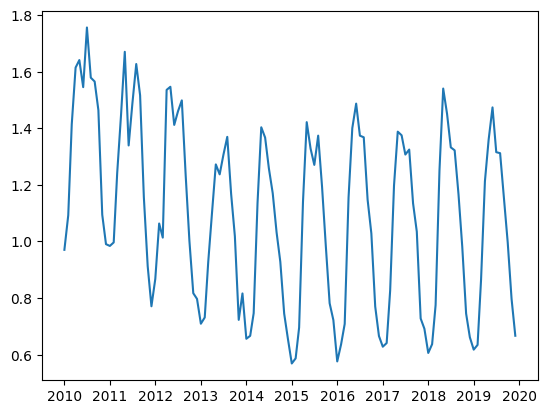

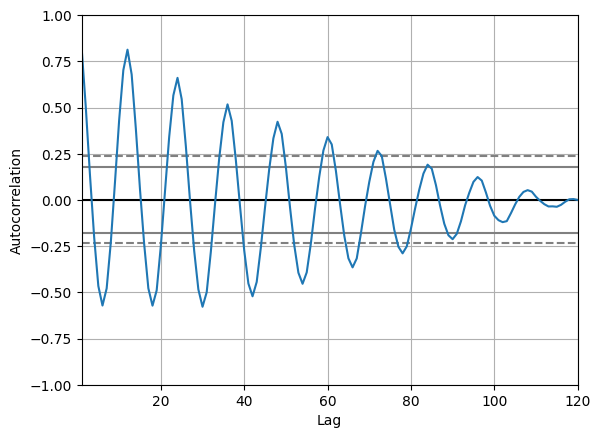

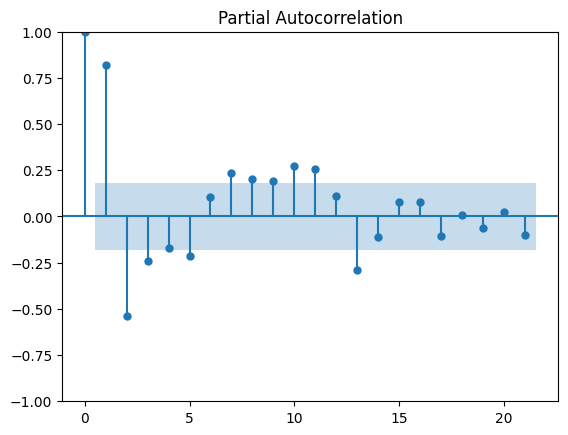

In [2]:
dfIT = pd.read_csv('Data_03.csv')
dfIT=dfIT.set_index('date')
dfIT = dfIT.loc[dfIT.index > '2009-12-01 ']
dfIT.index=pd.to_datetime(dfIT.index, format='%Y-%m-%d')

#The idea behind the next feature is: 'ratio' looks periodic, if it can be autocorrelated, then we have a good candidate for the forecasting!
dfIT['ratio'] = dfIT['Gas imported Mm3']/dfIT['Gas consumed Mm3']

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

plotter = dfIT.loc[(dfIT.loc[:,'ratio'].notna()) & (dfIT.index < '2020-01-01'),'ratio']
print('Analyzing feature: ' + plotter.name)

plt.plot(plotter)
plt.show()

#autocorrelation 
autocorrelation_plot(plotter)
plt.show()

#Partial autocorrelation
plot_pacf(plotter)
plt.show()

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  127
Model:                    AutoReg(12)   Log Likelihood                 121.648
Method:               Conditional MLE   S.D. of innovations              0.084
Date:                Fri, 10 May 2024   AIC                           -215.297
Time:                        17:08:01   BIC                           -176.868
Sample:                            12   HQIC                          -199.698
                                  127                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3138      0.077      4.075      0.000       0.163       0.465
y.L1           0.4264      0.083      5.155      0.000       0.264       0.589
y.L2          -0.1736      0.089     -1.960      0.0

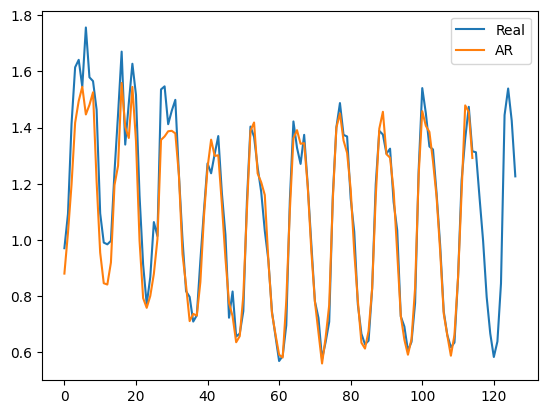

In [3]:
#Testing on itself
Y=dfIT.values[:,-1]

split_point = round(len(Y)*0.75)
train, test = Y[0:split_point], Y[split_point:]

# train autoregression
model = AutoReg(train, lags=[1,2,3,4,5,6,7,8,9,10,11,12], missing='drop')
model_fit = model.fit()

print(model_fit.summary())
plt.plot(train,label='Real')
plt.plot(model_fit.fittedvalues,label='AR')
plt.legend()

Looks acceptable, we may use it later.

Let's also try an analytical formulation for 'ratio', using sine waves to approximate it. We will also consider only from 2013 on, as in those years 'ratio' looks more "stable".

In [4]:
#Searching manually for appropriate indexes from 01-01-2014 to 02-02-2020
print(dfIT.loc[pd.to_datetime('2013-01-01',format='%Y-%m-%d'),'ratio'])
dfIT = dfIT.reset_index()
print(dfIT.values[36:122,-1])
dfIT = dfIT.set_index('date')
print(dfIT.loc[pd.to_datetime('2020-02-01',format='%Y-%m-%d'),'ratio'])

0.7092361522956695
[0.7092361522956695 0.7313189374678738 0.9269503528650049
 1.1045250646794833 1.2723261767168907 1.237090513521214 1.306167826759469
 1.3696213309662435 1.1677113623354822 1.0184320172048633
 0.7229169114067562 0.816253620410008 0.6560946745562131
 0.6664751508187302 0.7463791968400263 1.1363085132185302
 1.403494623655914 1.3670286828181566 1.258554154875225 1.1704582921200133
 1.0320388349514562 0.92771608970172 0.744814362907443 0.6556430446194226
 0.5687578850785641 0.5867952522255193 0.6959401094154909
 1.1401031158932975 1.4216508795669824 1.3280088129991738
 1.2704900021973193 1.3739698778061948 1.1940406976744187
 0.9861627426683188 0.7816091954022989 0.7220572514550422
 0.5761060008760402 0.6364120308756986 0.708511243951039 1.15578231292517
 1.4004790419161677 1.4870828848223896 1.3738964447625865
 1.368080921607193 1.1473684210526316 1.028393966282165 0.7700656572423958
 0.6658190294553931 0.6280405708643748 0.6410002475860361
 0.8263749807425667 1.1975180

Trying with a single sine wave

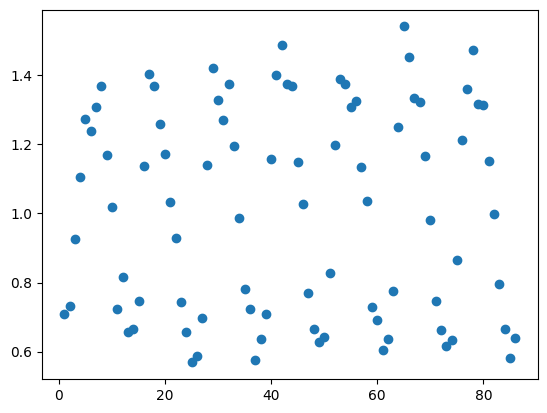

Amplitude=0.40, Angular freq.=0.52, phase=-1.94, offset=1.02, Max. Cov.=0.004504


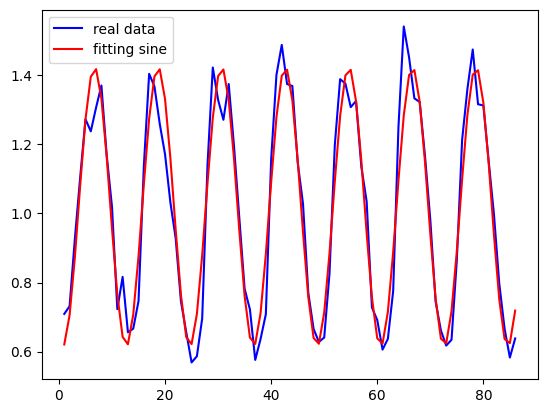

In [5]:
import numpy as np
import scipy.optimize

yy = dfIT.values[36:122,-1]
tt = np.arange(1,len(yy)+1,1)

plt.scatter(tt, yy)
plt.show()

def fit_sin(tt, yy):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # Assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # Exclude the zero frequency peak related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.0 * np.pi * guess_freq, 0.0, guess_offset])

    def sinfunc(t, A, w, p, c):
        return A * np.sin(w * t + p) + c

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    fitfunc = lambda t: A * np.sin(w * t + p) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": 1.0 / f,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov)
    }

def sinfunc(t, A, w, p, c):
        return A * np.sin(w * t + p) + c

res1 = fit_sin(tt, yy)
print(f"Amplitude={res1['amp']:.2f}, Angular freq.={res1['omega']:.2f}, phase={res1['phase']:.2f}, offset={res1['offset']:.2f}, Max. Cov.={res1['maxcov']:.6f}")

yy1 = sinfunc(tt, res1['amp'], res1['omega'], res1['phase'], res1['offset'])
plt.plot(tt, yy, "-b", label="real data")
plt.plot(tt, yy1, "-r", label="fitting sine")
plt.legend(loc="upper left")
plt.show()

Trying with multiple sine waves

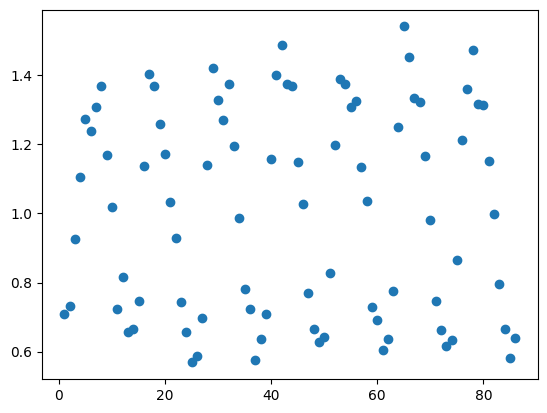

Amplitude=[-1.90728201e-02  2.56092229e+01 -2.56304574e+01  1.01794163e+00], Angular freq.=[0.18349287 0.52430009 0.52433887], phase=[16.23729789 -6.61575918 -6.60179428], offset=1.0179416340613496, Max. Cov.=3650628025977.4937


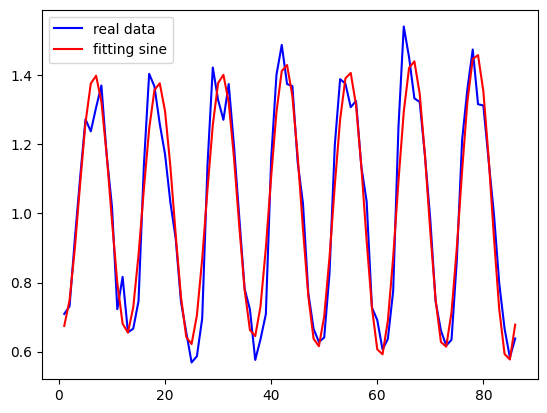

In [6]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

yy = dfIT.values[36:122, -1]
tt = np.arange(1, len(yy) + 1, 1)

plt.scatter(tt, yy)
plt.show()

def fit_sin(tt, yy, n=7):
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # Assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])  # Exclude the zero frequency peak related to offset
    guess_amp = np.std(yy) * 2.0 ** 0.5
    guess_offset = np.mean(yy)
    guess = [guess_amp, 2.0 * np.pi * guess_freq, 0.0, guess_offset]

    for _ in range(1, n):
        guess.extend([guess_amp, 2.0 * np.pi * guess_freq, 0.0])

    def sinfunc(t, *params):
        A = params[::3]
        w = params[1::3]
        p = params[2::3]
        c = params[-1]
        res = c
        for i in range(n):
            res += A[i] * np.sin(w[i] * t + p[i])
        return res

    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A = popt[::3]
    w = popt[1::3]
    p = popt[2::3]
    c = popt[-1]

    fitfunc = lambda t: c
    for i in range(n):
        fitfunc = lambda t, i=i, fitfunc=fitfunc: fitfunc(t) + A[i] * np.sin(w[i] * t + p[i])

    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov)
    }

res2 = fit_sin(tt, yy, n=3)
print(f"Amplitude={res2['amp']}, Angular freq.={res2['omega']}, phase={res2['phase']}, offset={res2['offset']}, Max. Cov.={res2['maxcov']}")

yy2 = res2['fitfunc'](tt)
plt.plot(tt, yy, "-b", label="real data")
plt.plot(tt, yy2, "-r", label="fitting sine")
plt.legend(loc="upper left")
plt.show()

We will try to use these estimators in the following, as well as creating additional features

### Feature engineering

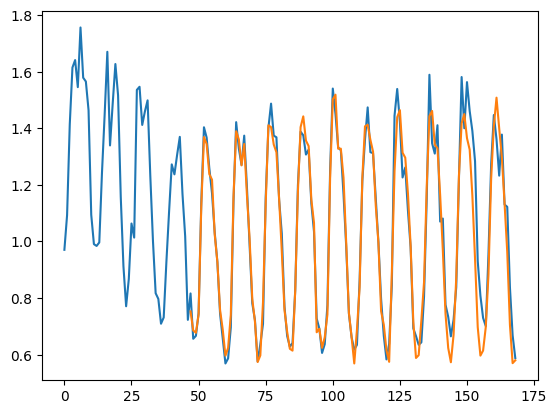

In [7]:
#'ratio' autoestimator

window = list(range(1,48))
Y = dfIT.values[:,-1]

split_point = 122
train, test = Y[0:split_point], Y[split_point:]

# train autoregression
model = AutoReg(train, lags=window, missing='drop')
model_fit = model.fit()

# forecast
predictions = model.predict(start=0, end=len(Y)-1, params=model_fit.params)

# plot
plt.plot(Y)
plt.plot(predictions)
plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_18200\3235244958.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 0.         0.09090909 0.18181818 0.27272727 0.36363636 0.45454545
 0.54545455 0.63636364 0.72727273 0.81818182 0.90909091 1.
 0.         0.09090909 0.18181818 0.27272727 0.36363636 0.454

Correlation matrix for values between 2013 and 2020


Electricity import (GWh)                     -0.121986
Electricity generated from natural gas GWh   -0.083196
Total electricity generated GWh               0.349751
Fraction of electricity generated by gas     -0.157445
Gas produced Mm3                             -0.468812
Gas consumed Mm3                              0.398143
Gas exported Mm3                              0.202775
Gas imported Mm3                              1.000000
Total Gas Stocks Mm3                         -0.082711
Average Temperature (°C)                     -0.179483
to Albania                                         NaN
to Austria                                    0.099620
to Slovenia                                  -0.330953
to Switzerland                                0.355883
from Albania                                       NaN
from Austria                                  0.583362
from Croatia                                 -0.379711
from Libya                                   -0.365175
from Lique

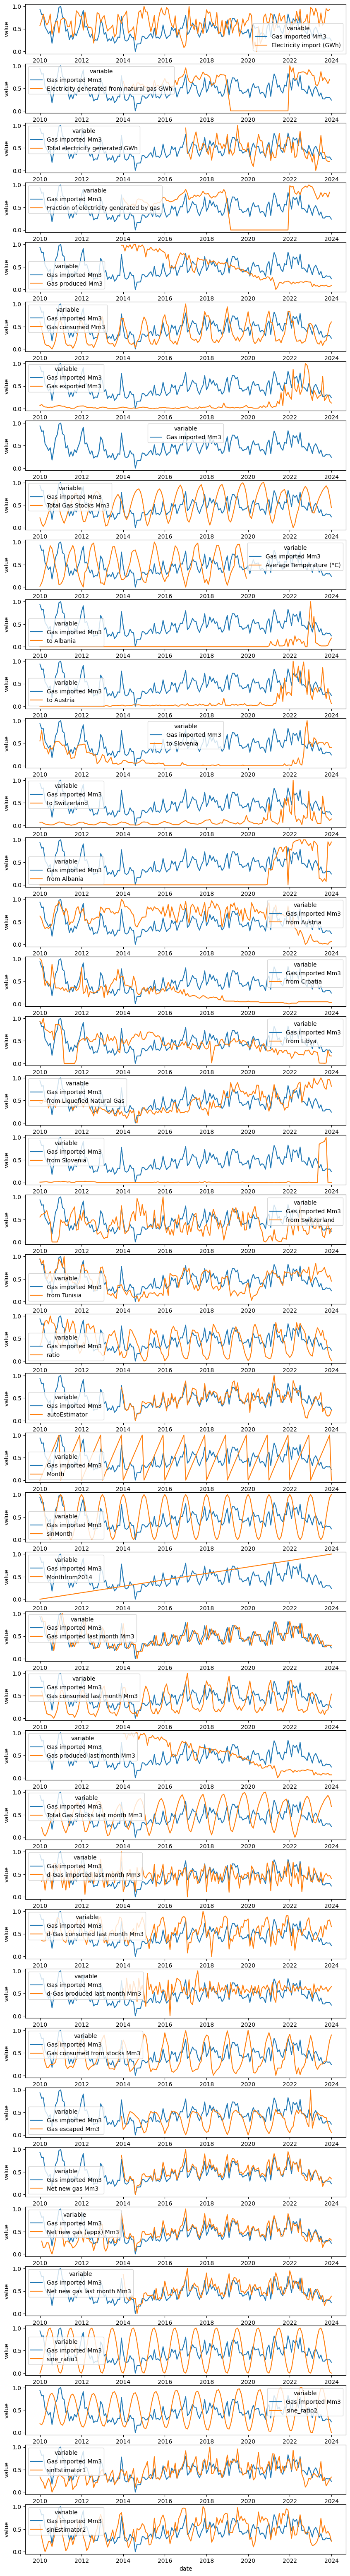

In [8]:
#'ratio' autoestimator
dfIT['autoEstimator'] = predictions*dfIT['Gas consumed Mm3']

#Extracting features
dfIT['Month'] = dfIT.index.month
dfIT['sinMonth'] = (1 + np.sin((dfIT['Month']+2)/6*np.pi))/2 #January is numerically close to December
dfIT['Monthfrom2014'] = np.arange(-36, 169-36, 1) #counting months by having 0 at 2013-01-01, positive months after that, negative before

#Shifting features
dfIT['Gas imported last month Mm3'] = dfIT['Gas imported Mm3'].shift(1) # Gas imported the last month
dfIT['Gas consumed last month Mm3'] = dfIT['Gas consumed Mm3'].shift(1) # Gas consumed the last month
dfIT.loc[pd.to_datetime('2013-12-01',format="%Y-%m-%d"),'Gas produced Mm3'] = dfIT.loc[pd.to_datetime('2014-01-01',format="%Y-%m-%d"),'Gas produced Mm3'] #to have full 2014
dfIT['Gas produced last month Mm3'] = dfIT['Gas produced Mm3'].shift(1) # Gas produced the last month
dfIT['Total Gas Stocks last month Mm3'] = dfIT['Total Gas Stocks Mm3'].shift(1) # Gas stocks the last month

#Derivative features - the idea is to make a finite differences point-wise derivative, this is actually just a difference since the time window is 1 month
dfIT['d-Gas imported last month Mm3'] = dfIT['Gas imported Mm3'] - dfIT['Gas imported Mm3'].shift(1)
dfIT['d-Gas consumed last month Mm3'] = dfIT['Gas consumed Mm3'] - dfIT['Gas consumed Mm3'].shift(1) 
dfIT['d-Gas produced last month Mm3'] = dfIT['Gas produced Mm3'] - dfIT['Gas produced Mm3'].shift(1) 

#Balance features
dfIT['Gas consumed from stocks Mm3'] = dfIT['Total Gas Stocks Mm3'].shift(1) - dfIT['Total Gas Stocks Mm3'] #Gas that exited the reserves in 1 month
dfIT['Gas escaped Mm3'] = dfIT['Gas imported Mm3'] - dfIT['Gas exported Mm3'] + dfIT['Gas produced Mm3'] - dfIT['Gas consumed Mm3'] + dfIT['Gas consumed from stocks Mm3'] #This should be zero but it itsn't, it should be a relative error of some sort
dfIT['Net new gas Mm3'] = dfIT['Gas consumed Mm3'] - dfIT['Gas consumed from stocks Mm3'] - dfIT['Gas produced Mm3'] #Gas available for export or consumption
dfIT['Net new gas (appx) Mm3'] = dfIT['Gas consumed Mm3'] - dfIT['Gas consumed from stocks Mm3'] #As before but neglecting production
#Since exports and production in Italy are low, the last 2 features should mimick the imports.

#Composite features
dfIT['Net new gas last month Mm3'] = dfIT['Net new gas Mm3'].shift(1)
#dfIT['Net new gas estimator'] = dfIT['Net new gas last month Mm3']+dfIT['d-Gas imported last month Mm3']

#Let's see the analytical estimators for 'ratio' in action!
dfIT['sine_ratio1'] = sinfunc(dfIT['Month'], res1['amp'], res1['omega'], res1['phase'], res1['offset'])
dfIT['sine_ratio2'] = res2['fitfunc'](dfIT['Monthfrom2014'])
dfIT['sinEstimator1'] = dfIT['Gas consumed Mm3']*dfIT['sine_ratio1']
dfIT['sinEstimator2'] = dfIT['Gas consumed Mm3']*dfIT['sine_ratio2']

#Plotting normalized data
dfITn = dfIT.copy(deep=True)

for column in dfITn.columns: #what I do here is put all values on a scale from 0 to 1, where 0 corresponds to min value and 1 to max value
    dfITn.loc[:,column] = (dfITn.loc[:,column] - dfITn.loc[:,column].min())/(dfITn.loc[:,column].max() - dfITn.loc[:,column].min())

dfITn = dfITn.reset_index()

fig, axes = plt.subplots(len(dfITn.columns)-1,1,figsize = (10,80))

j = 1
for i in range(0,len(dfITn.columns)-1):
    sb.lineplot(x='date', y='value', hue='variable',data = pd.melt(dfITn[['date','Gas imported Mm3',dfITn.columns[j]]], ['date']), ax=axes[i])
    j = j + 1

dfITn = dfITn.set_index('date')
pd.set_option('display.max_rows', 1000)

print('Correlation matrix for values between 2013 and 2020')
display(dfITn.loc[(dfITn.index < pd.to_datetime('2020-01-01',format='%Y-%m-%d')) &(dfITn.index > pd.to_datetime('2012-12-01',format='%Y-%m-%d')),:].corr().loc[:,'Gas imported Mm3'])

#Saving correlation scores
corr_features = dfITn.loc[(dfITn.index < pd.to_datetime('2020-01-01',format='%Y-%m-%d')) &(dfITn.index > pd.to_datetime('2012-12-01',format='%Y-%m-%d')),:].corr().loc[:,'Gas imported Mm3']
corr_features = pd.DataFrame({'Name': corr_features.index, 'Score': corr_features.values})
corr_features.loc[:,'Score'] = corr_features.loc[:,'Score'].abs()
corr_features = corr_features.sort_values(by='Score',ascending=False)
corr_features = corr_features.reset_index()
corr_features = corr_features.drop(columns=['index'])

We have generated some features, let's see how well they perform according to our feature selection methods.

### Feature selection

First, let's remove data after 2020-02-01

In [9]:
dfIT = dfIT.loc[dfIT.index < '2020-01-01']
dfIT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2010-01-01 to 2019-12-01
Data columns (total 43 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Electricity import (GWh)                    120 non-null    float64
 1   Electricity generated from natural gas GWh  66 non-null     float64
 2   Total electricity generated GWh             36 non-null     float64
 3   Fraction of electricity generated by gas    66 non-null     float64
 4   Gas produced Mm3                            73 non-null     float64
 5   Gas consumed Mm3                            120 non-null    float64
 6   Gas exported Mm3                            120 non-null    float64
 7   Gas imported Mm3                            120 non-null    float64
 8   Total Gas Stocks Mm3                        120 non-null    float64
 9   Average Temperature (°C)                    120 non-null    float64


Let's drop 'Total electricity generated GWh' as it has too many NaNs and we cannot forecast it by autoregression. The other criteria we use to drop the features with lots of NaNs is their low influence on imports.

In [10]:
dfIT = dfIT.drop(columns=['Total electricity generated GWh','Electricity generated from natural gas GWh','Fraction of electricity generated by gas'])

Next, we will study the dataframe only where no values have NaNs, that is from 2014 on. If features which only appear after 2014 are considered impactful, then we will keep them and decide if they are good enough to forecast from 2020 on. If not, we will drop them and resume with the dataframe at this point.

In [11]:
print(dfIT.loc[dfIT.index > pd.to_datetime('2013-12-01',format='%Y-%m-%d')].info()) #study if we have NaNs

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72 entries, 2014-01-01 to 2019-12-01
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Electricity import (GWh)         72 non-null     float64
 1   Gas produced Mm3                 72 non-null     float64
 2   Gas consumed Mm3                 72 non-null     float64
 3   Gas exported Mm3                 72 non-null     float64
 4   Gas imported Mm3                 72 non-null     float64
 5   Total Gas Stocks Mm3             72 non-null     float64
 6   Average Temperature (°C)         72 non-null     float64
 7   to Albania                       72 non-null     float64
 8   to Austria                       72 non-null     float64
 9   to Slovenia                      72 non-null     float64
 10  to Switzerland                   72 non-null     float64
 11  from Albania                     72 non-null     float64
 12  from

In [12]:
dfIT.insert(0, 'Gas imported Mm3', dfIT.pop('Gas imported Mm3')) #Moving the column to the first position
dfITr = dfIT.loc[dfIT.index > pd.to_datetime('2013-12-01',format='%Y-%m-%d')] #reduced dataframe
print(dfITr.columns)

Index(['Gas imported Mm3', 'Electricity import (GWh)', 'Gas produced Mm3',
       'Gas consumed Mm3', 'Gas exported Mm3', 'Total Gas Stocks Mm3',
       'Average Temperature (°C)', 'to Albania', 'to Austria', 'to Slovenia',
       'to Switzerland', 'from Albania', 'from Austria', 'from Croatia',
       'from Libya', 'from Liquefied Natural Gas', 'from Slovenia',
       'from Switzerland', 'from Tunisia', 'ratio', 'autoEstimator', 'Month',
       'sinMonth', 'Monthfrom2014', 'Gas imported last month Mm3',
       'Gas consumed last month Mm3', 'Gas produced last month Mm3',
       'Total Gas Stocks last month Mm3', 'd-Gas imported last month Mm3',
       'd-Gas consumed last month Mm3', 'd-Gas produced last month Mm3',
       'Gas consumed from stocks Mm3', 'Gas escaped Mm3', 'Net new gas Mm3',
       'Net new gas (appx) Mm3', 'Net new gas last month Mm3', 'sine_ratio1',
       'sine_ratio2', 'sinEstimator1', 'sinEstimator2'],
      dtype='object')


Then, let's try some selection methods. We will start with k-best

,Name,Score
0,Net new gas Mm3,1053.494776
1,autoEstimator,748.822829
2,Net new gas (appx) Mm3,731.526814
3,sinEstimator1,96.645284
4,from Austria,40.144363
5,Monthfrom2014,37.063845
6,Gas imported last month Mm3,34.780832
7,Net new gas last month Mm3,32.568561
8,Gas produced Mm3,28.705796
9,Gas produced last month Mm3,28.145967


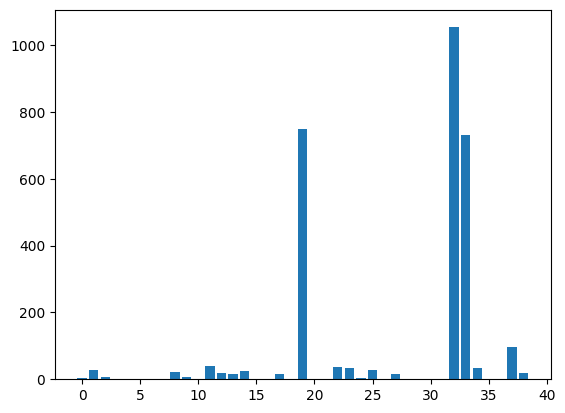

In [13]:
# Define input and outputs
Z = dfITr.values
Z = np.array(Z[:,0:len(dfITr.columns)],dtype=float)
Y = Z[:,0]
X = Z[:,range(1,len(dfITr.columns))]

#Let's see what kbest has to say
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import mutual_info_regression,f_regression 
features=SelectKBest(k='all',score_func=f_regression)
fit=features.fit(X,Y) 
features_results=fit.transform(X)
plt.bar([i for i in range(len(fit.scores_))], fit.scores_)

#Printing the features' names
indices = np.argsort(fit.scores_)[::-1]

k_features = []
k_scores = []
for i in range(len(fit.scores_)-1):
    k_features.append(dfITr.columns[indices[i]+1])
    k_scores.append(fit.scores_[indices[i]])

#Saving the features scores
k_features = pd.DataFrame({'Name': k_features, 'Score': k_scores})
display(k_features)

Now let's see a wrapper method

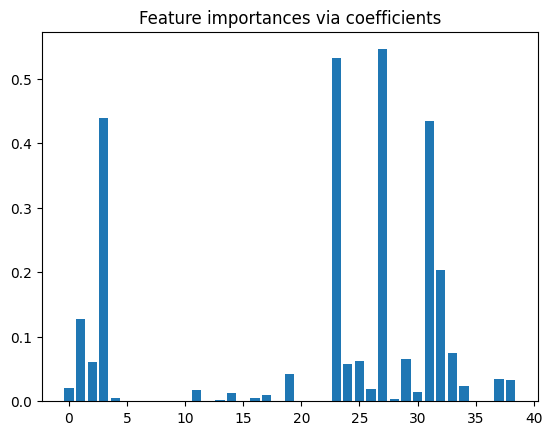

Features selected by forward sequential selection: ['to Austria' 'to Slovenia' 'to Switzerland' 'from Switzerland'
 'from Tunisia' 'Month' 'Monthfrom2014' 'Gas consumed from stocks Mm3'
 'Net new gas Mm3' 'sinEstimator2']


,Name,Score
0,d-Gas imported last month Mm3,0.545364
1,Gas imported last month Mm3,0.531686
2,Gas exported Mm3,0.439269
3,Gas escaped Mm3,0.434893
4,Net new gas Mm3,0.202887
5,Gas produced Mm3,0.127903
6,Net new gas (appx) Mm3,0.074984
7,d-Gas produced last month Mm3,0.065722
8,Gas produced last month Mm3,0.062181
9,Gas consumed Mm3,0.061099


In [14]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X, Y)
importance = np.abs(ridge.coef_)
feature_names = np.arange(0,len(importance))

plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

from sklearn.feature_selection import SequentialFeatureSelector

sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="forward"
).fit(X, Y)

feature_names = np.array(dfITr.columns[dfIT.columns != 'Gas imported Mm3'])
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
)


indices = np.argsort(importance)[::-1]

#Printing the features' names
Wrap_features = []
Wrap_scores = []
for i in range(len(ridge.coef_)-1):
    Wrap_features.append(dfITr.columns[indices[i]+1])
    Wrap_scores.append(np.abs(ridge.coef_)[indices[i]])

#Saving the features scores
Wrap_features = pd.DataFrame({'Name': Wrap_features, 'Score': Wrap_scores})
display(Wrap_features)

Let's try an ensemble method with the Random Forest Regressor, which has proved to be good in our projects

,Name,Score
0,Net new gas Mm3,1053.494776
1,Net new gas (appx) Mm3,748.822829
2,autoEstimator,731.526814
3,from Liquefied Natural Gas,96.645284
4,from Austria,40.144363
5,Net new gas last month Mm3,37.063845
6,sinEstimator1,34.780832
7,Gas produced last month Mm3,32.568561
8,Gas imported last month Mm3,28.705796
9,from Tunisia,28.145967


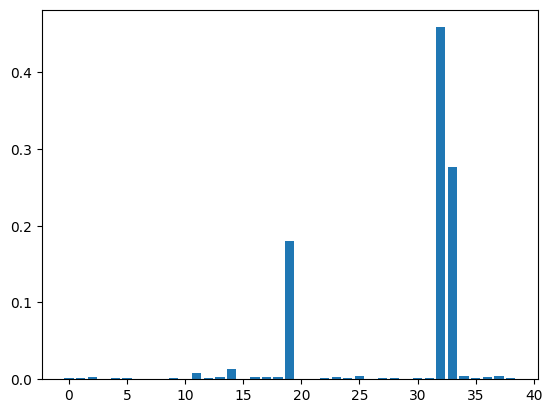

In [15]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X, Y)

#Printing the features' names
indices = np.argsort(model.feature_importances_)[::-1]

plt.bar([i for i in range(len(model.feature_importances_))], model.feature_importances_)

RF_features = []
RF_scores = []
for i in range(len(model.feature_importances_)-1):
    RF_features.append(dfITr.columns[indices[i]+1])
    RF_scores.append(model.feature_importances_[indices[i]])

#Saving scores
RF_features = pd.DataFrame({'Name': RF_features, 'Score': k_scores})

display(RF_features)

Let's see and compare the results

In [16]:
corr_features = corr_features.reset_index()
corr_features.rename(columns=lambda col: col.replace('index', 'Rank by correlation'), inplace=True)
corr_features = corr_features.set_index('Name')
corr_features.rename(columns=lambda col: col.replace('Score', 'Score by correlation'), inplace=True)

k_features = k_features.reset_index()
k_features.rename(columns=lambda col: col.replace('index', 'Rank by k-best'), inplace=True)
k_features = k_features.set_index('Name')
k_features.rename(columns=lambda col: col.replace('Score', 'Score by k-best filter'), inplace=True)

Wrap_features = Wrap_features.reset_index()
Wrap_features.rename(columns=lambda col: col.replace('index', 'Rank by RFE,ridge wrapper'), inplace=True)
Wrap_features = Wrap_features.set_index('Name')
Wrap_features.rename(columns=lambda col: col.replace('Score', 'Score by RFE,ridge wrapper'), inplace=True)

RF_features = RF_features.reset_index()
RF_features.rename(columns=lambda col: col.replace('index', 'Rank by RFR embedded method'), inplace=True)
RF_features = RF_features.set_index('Name')
RF_features.rename(columns=lambda col: col.replace('Score', 'Score by RFR embedded method'), inplace=True)

featurescores = pd.DataFrame(index=corr_features.index)
featurescores = pd.concat([corr_features, k_features, Wrap_features,RF_features], axis=1)

display(featurescores)

,Rank by correlation,Score by correlation,Rank by k-best,Score by k-best filter,"Rank by RFE,ridge wrapper","Score by RFE,ridge wrapper",Rank by RFR embedded method,Score by RFR embedded method
Name,,,,,,,,
Gas imported Mm3,0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Net new gas Mm3,1,0.969961,0.0,1053.494776,4.0,0.202887,0.0,1053.494776
autoEstimator,2,0.954143,1.0,748.822829,11.0,0.042034,2.0,731.526814
Net new gas (appx) Mm3,3,0.900534,2.0,731.526814,6.0,0.074984,1.0,748.822829
sinEstimator1,4,0.752342,3.0,96.645284,12.0,0.034696,6.0,34.780832
from Austria,5,0.583362,4.0,40.144363,17.0,0.017276,4.0,40.144363
Gas imported last month Mm3,6,0.564295,6.0,34.780832,1.0,0.531686,8.0,28.705796
Net new gas last month Mm3,7,0.563498,7.0,32.568561,14.0,0.024111,5.0,37.063845
Gas produced last month Mm3,8,0.535515,9.0,28.145967,8.0,0.062181,7.0,32.568561


We will decide to keep these features for the imports forecast: Net new gas (appx) Mm3, autoEstimator, sinEstimator1, Gas imported last month Mm3, Net new gas last month Mm3. Or, better, we will save the features needed to make them. This means we will extend the features we need up to 31-12-2023 via the autoregression we tested or in similar ways and then forecast Italian gas imports.

In [17]:
dfIT = dfIT.loc[:,['ratio','Gas consumed Mm3','Gas consumed from stocks Mm3','Total Gas Stocks Mm3','Gas imported Mm3']]
dfIT.to_csv('Data_04.csv', index=True)